## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
from_DB = True
path_to_feather = "..//..//data//feathers//"

cids = ['BRL', 'CLP', 'CNY', 'COP', 'HUF', 'IDR', 'INR', 'KRW', 'MYR', 'MXN', 'PEN', 'PHP', 
        'PLN', 'RON', 'RUB', 'SGD', 'THB','TRY', 'TWD', 'ZAR']
cats = ['ACTIND', 'SURVLEAD', 'SURVCOIN', 'BCSURV', 'BUILDPERMITS', 'CAPUTIL', 'CARSALES', 'CCSURV', 'CONS',
        'CONSTR', 'EMPL', 'ESI', 'HSTARTS', 'IP', 'IPNEWORDERS', 'MGDP', 'PMICOMP', 'PMIMANU', 'PMISERV', 'REXPORTS',
        'RSV', 'SURVMANU', 'UNEMPL', 'UNEMPLRATE', 'IPMANU', 'IPMINING', 'RSVAL', 'RSVOL', 'WSVOL']

if from_DB:
    dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                              password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
    dfm = dbi.get_series_values(category=cats, cross_section=cids, frequency="m")  # import grade 1 vintages
    dfm.to_feather(f'{path_to_feather}dfm_act_em.ftr')
else:
    dfm = pd.read_feather(f'{path_to_feather}dfm_act_em.ftr')

In [3]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4358781 entries, 0 to 4358780
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cross_section     object 
 1   category_code     object 
 2   adjustment        object 
 3   transformation    object 
 4   release_date      object 
 5   observation_date  object 
 6   value             float64
 7   grading           object 
dtypes: float64(1), object(7)
memory usage: 266.0+ MB


In [4]:
dfm['ticker'] = dfm['cross_section'] + '_' + dfm['category_code'] + '_' + dfm['adjustment']
ind_trans = ~dfm['transformation'].isnull()  # indexing locations with transforms
dfm.loc[ind_trans, 'ticker'] = dfm.loc[ind_trans, 'ticker'] + '_' + dfm.loc[ind_trans, 'transformation']

## Documentation

In [5]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", database="qs_jpm_point_time")
docs = dbi.get_series_documentation(category=cats, frequency="m")
docs = docs.sort_values(by = 'cross_section')

In [6]:
docs[docs['cross_section']=='RUB']

cross_section category_code adjustment frequency  \
92            RUB            IP        NSA         m   
166           RUB    UNEMPLRATE        NSA         m   
109           RUB          MGDP        NSA         m   

                                         documentation  
92                    Reference data: (DS: RSPBCTT%R).  
166                   Reference data: (DS: RSUN%TOTR).  
109  Reference data: (MB: runaac0349), (DS: RSECSE8...

## Functions

In [9]:
def countmap(dfx, start_year, figsize=(12, 12), trueVin = False):
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    ticks = np.sort(dfx['ticker'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for tick in ticks:
        dfc = dfx.query('ticker == @tick').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["ticker"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    cds = dfx['cross_section'].unique()[0]
    ax.set_title(cds + ': Vintage lengths for last (available) release in year ', y = 1.1, fontsize=14)

In [10]:
def revlines(df, pots, ncols=2, size = (15, 5), mod = "None"):
    """mod can be DOYA, POYA and None"""
    
    ticks = np.sort(df['ticker'].unique())

    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    fig, axes = plt.subplots(nrows=math.ceil(len(ticks)/ncols), ncols=ncols, sharex=True, figsize=size)

    for i in range(len(ticks)):
        tick = ticks[i]
        dfc = df.query('ticker == @tick')
        releases = dfc['release_date'].unique()
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            dfcx_add = dfc[dfc['release_date'].isin([release])]
            if mod == 'POYA':
                dfcx_add['value'] = 100* dfcx_add['value'].pct_change(12)
            if mod == 'DOYA':
                dfcx_add['value'] = dfcx_add['value'].diff(12)
            dfcx = dfcx_add if (p == 0) else dfcx.append(dfcx_add)
        if len(ticks) > 1:
            if axes.ndim == 2:
                axe = axes[math.floor(i / ncols), (i % ncols)]
            else:
                axe = axes[i]
            sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                         hue="release_date", palette=colors, ax=axe)
            axe.set(title=tick, ylabel="", xlabel="")
            if mod != 'None':
                axe.set_title(tick + '_' + mod)
        else:
            sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                         hue="release_date", palette=colors)
            plt.xlabel('')
            plt.ylabel('')
            if mod != 'None':
                plt.title(tick + '_' + mod)
            else:
                plt.title(tick) 

    plt.show()

## BRL

In [10]:
dfm_brl = dfm[dfm['cross_section'] == 'BRL']
np.sort(dfm_brl['ticker'].unique())

array(['BRL_ACTIND_SA', 'BRL_BCSURV_NSA', 'BRL_CAPUTIL_SA',
       'BRL_CCSURV_NSA', 'BRL_IP_SA', 'BRL_RSVOL_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

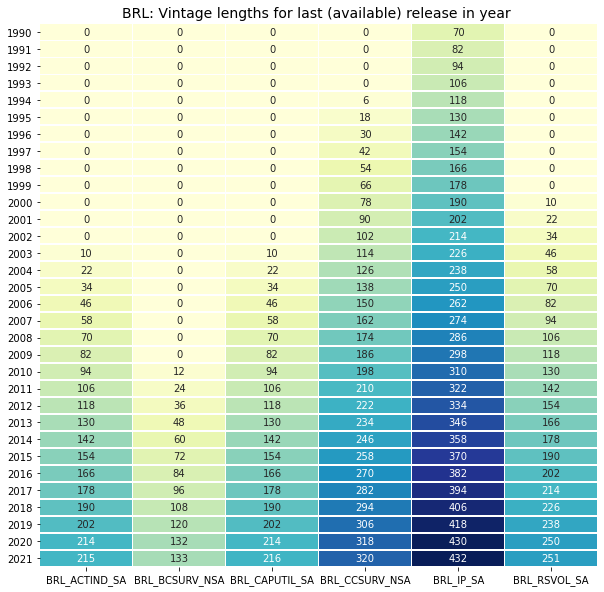

In [11]:
countmap(dfm_brl, 1990, (10, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

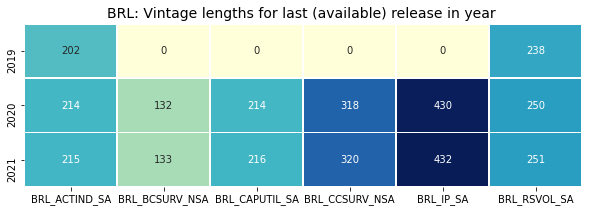

In [12]:
countmap(dfm_brl, 2000, (10, 3), trueVin = True)
plt.show

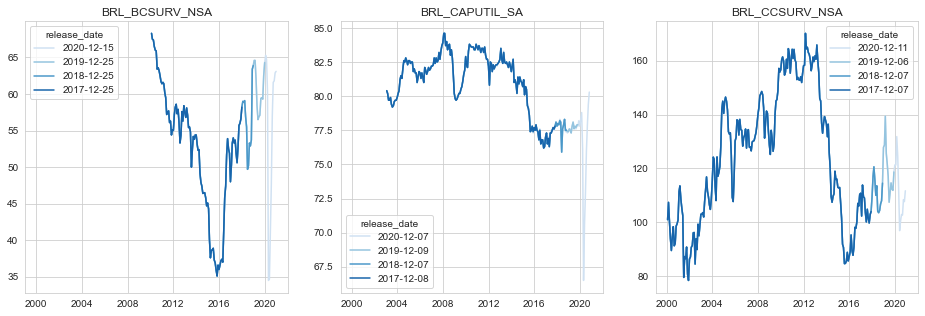

In [13]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_brl['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_brl['ticker'].isin(['BRL_BCSURV_NSA', 'BRL_CAPUTIL_SA','BRL_CCSURV_NSA'])
dfm_x = dfm_brl[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 5))

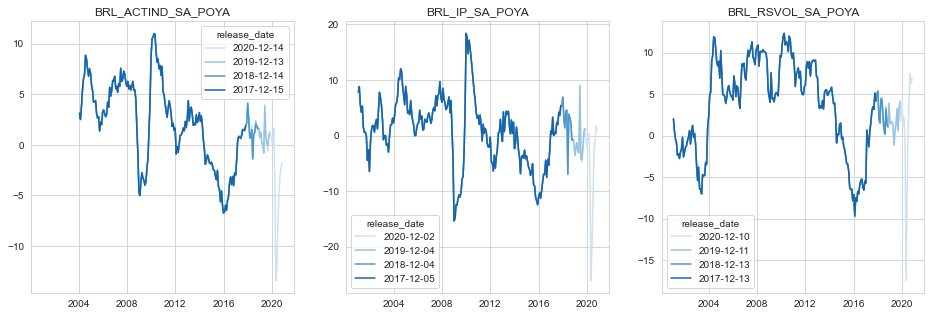

In [14]:
filt2 = dfm_brl['ticker'].isin(['BRL_ACTIND_SA', 'BRL_IP_SA', 'BRL_RSVOL_SA'])
dfm_x = dfm_brl[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=3, size = (16, 5), mod='POYA')

## CLP

In [15]:
dfm_clp = dfm[dfm['cross_section'] == 'CLP']
np.sort(dfm_clp['ticker'].unique())

array(['CLP_ACTIND_SA', 'CLP_BCSURV_NSA', 'CLP_CCSURV_NSA',
       'CLP_IPMANU_NSA', 'CLP_RSVOL_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

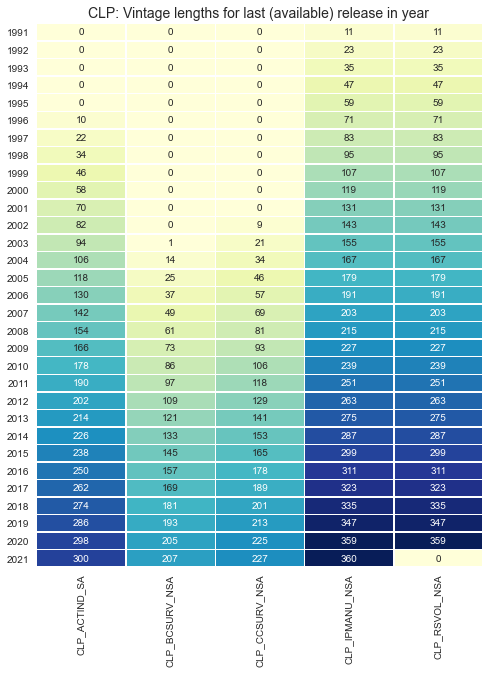

In [16]:
countmap(dfm_clp, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

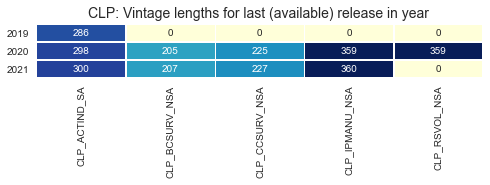

In [17]:
countmap(dfm_clp, 2000, (8, 1), trueVin = True)
plt.show

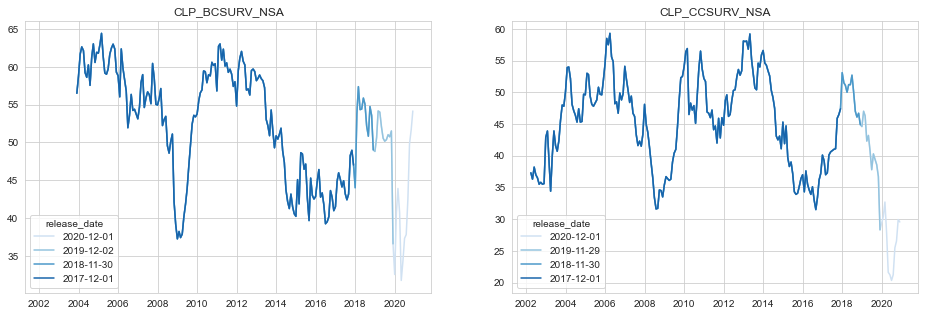

In [18]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_clp['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_clp['ticker'].isin(['CLP_BCSURV_NSA', 'CLP_CCSURV_NSA'])
dfm_x = dfm_clp[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

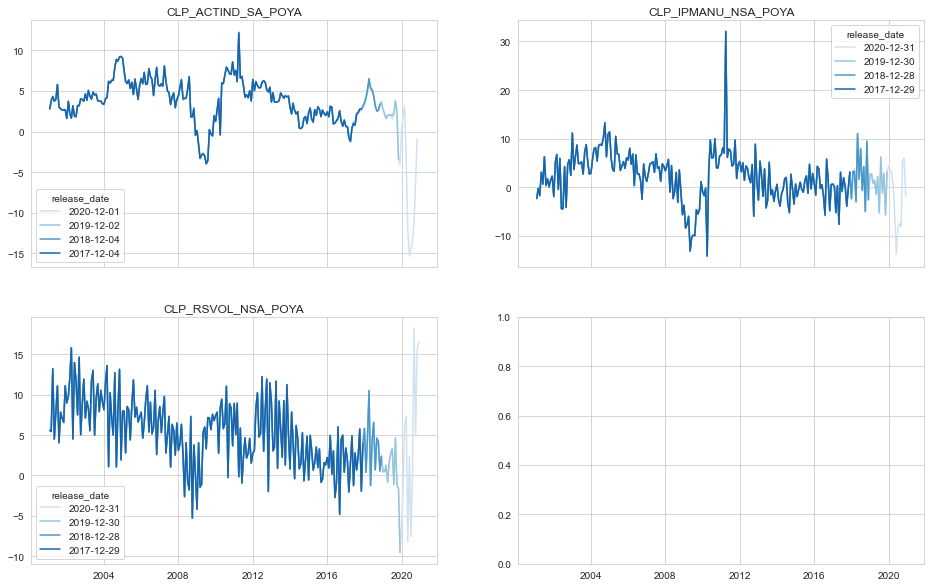

In [19]:
filt2 = dfm_clp['ticker'].isin(['CLP_ACTIND_SA', 'CLP_IPMANU_NSA', 'CLP_RSVOL_NSA'])
dfm_x = dfm_clp[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod='POYA')

## CNY

In [20]:
dfm_cny = dfm[dfm['cross_section'] == 'CNY']
np.sort(dfm_cny['ticker'].unique())

array(['CNY_CCSURV_NSA', 'CNY_IP_NSA', 'CNY_PMIMANU_SA', 'CNY_RSVAL_NSA'],
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

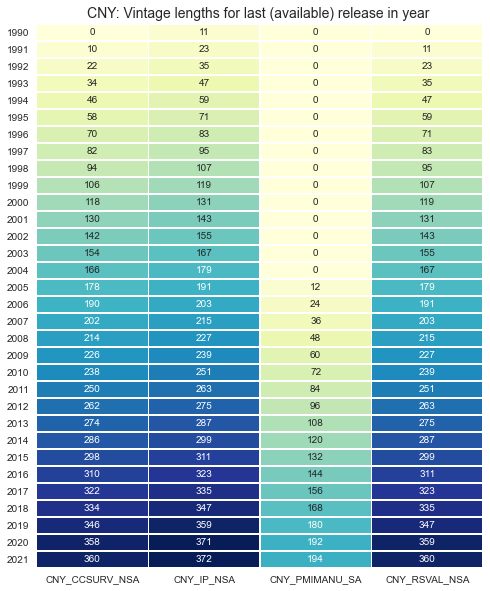

In [21]:
countmap(dfm_cny, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

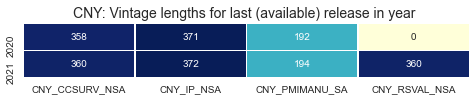

In [22]:
countmap(dfm_cny, 2000, (8, 1), trueVin = True)
plt.show

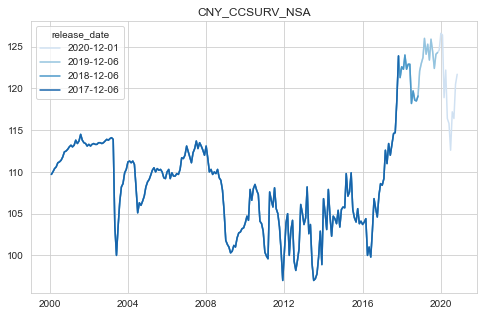

In [23]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_cny['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_cny['ticker'].isin(['CNY_CCSURV_NSA'])
dfm_x = dfm_cny[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

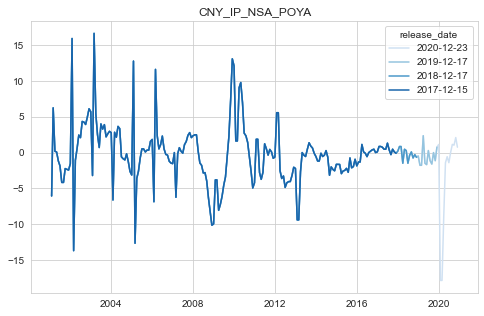

In [24]:
filt2 = dfm_cny['ticker'].isin(['CNY_IP_NSA'])
dfm_x = dfm_cny[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='POYA')

## COP

In [7]:
dfm_cop = dfm[dfm['cross_section'] == 'COP']
np.sort(dfm_cop['ticker'].unique())

array(['COP_CAPUTIL_NSA', 'COP_CCSURV_NSA', 'COP_IP_NSA', 'COP_RSVAL_SA',
       'COP_UNEMPLRATE_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

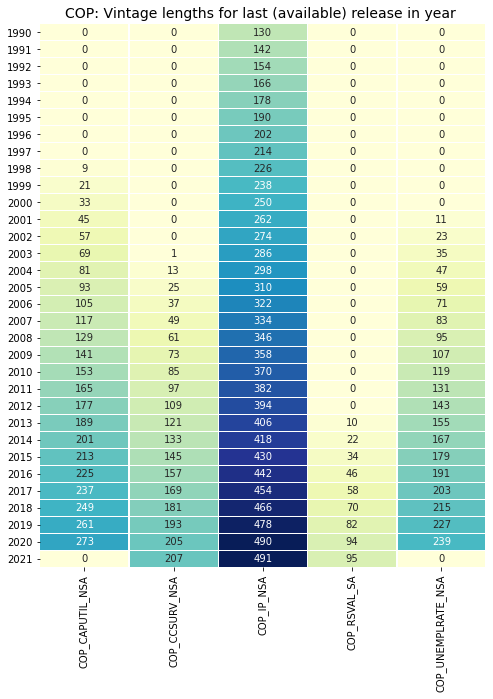

In [11]:
countmap(dfm_cop, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

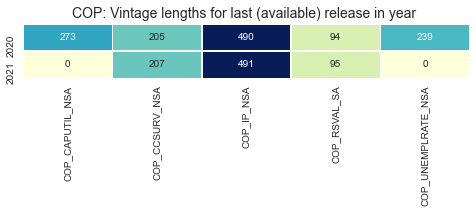

In [27]:
countmap(dfm_cop, 2000, (8, 1), trueVin = True)
plt.show

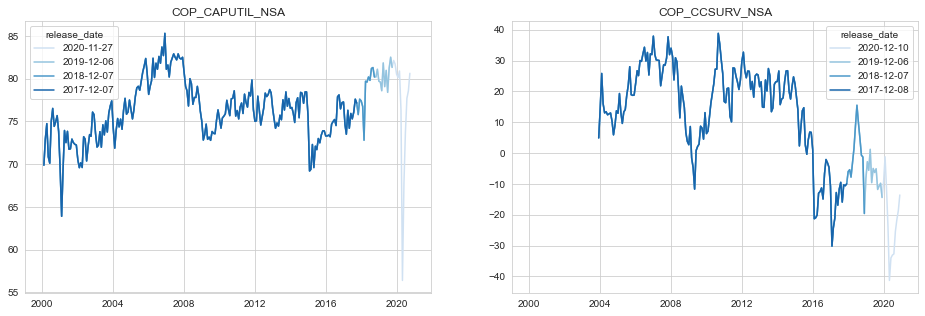

In [28]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_cop['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_cop['ticker'].isin(['COP_CAPUTIL_NSA', 'COP_CCSURV_NSA'])
dfm_x = dfm_cop[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

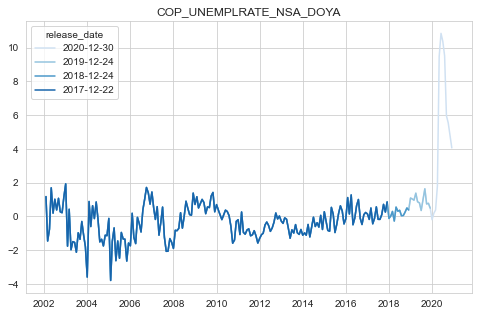

In [29]:
filt2 = dfm_cop['ticker'].isin(['COP_UNEMPLRATE_NSA'])
dfm_x = dfm_cop[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

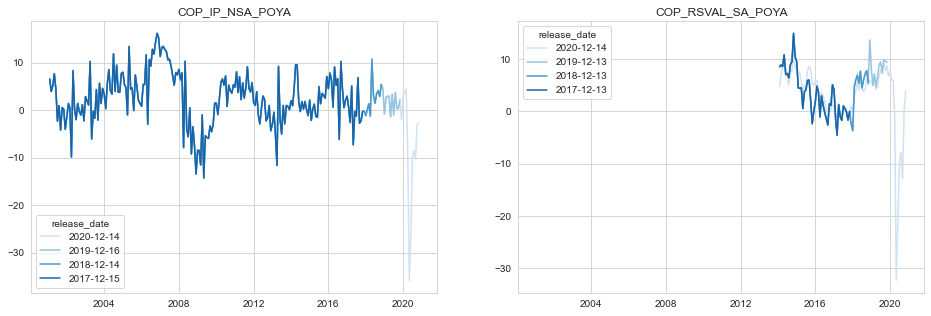

In [30]:
filt2 = dfm_cop['ticker'].isin(['COP_IP_NSA', 'COP_RSVAL_SA'])
dfm_x = dfm_cop[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod='POYA')

## HUF

In [31]:
dfm_huf = dfm[dfm['cross_section'] == 'HUF']
np.sort(dfm_huf['ticker'].unique())

array(['HUF_BCSURV_SA', 'HUF_CCSURV_SA', 'HUF_CONSTR_SA', 'HUF_ESI_SA',
       'HUF_IP_SA', 'HUF_RSVOL_NSA', 'HUF_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

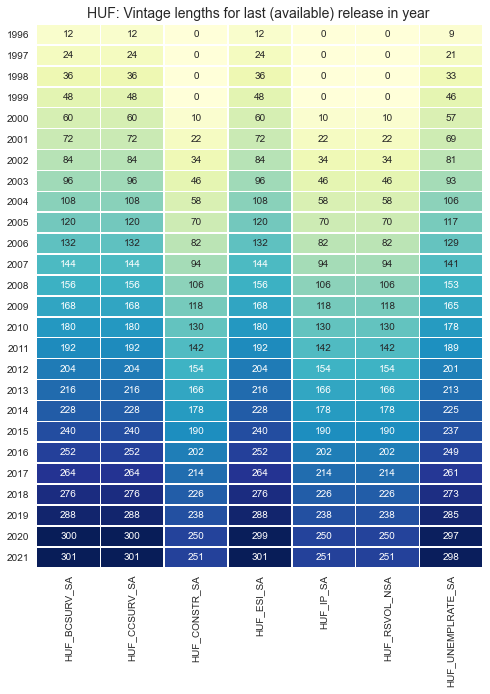

In [32]:
countmap(dfm_huf, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

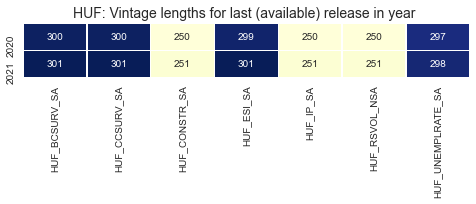

In [33]:
countmap(dfm_huf, 2000, (8, 1), trueVin = True)
plt.show

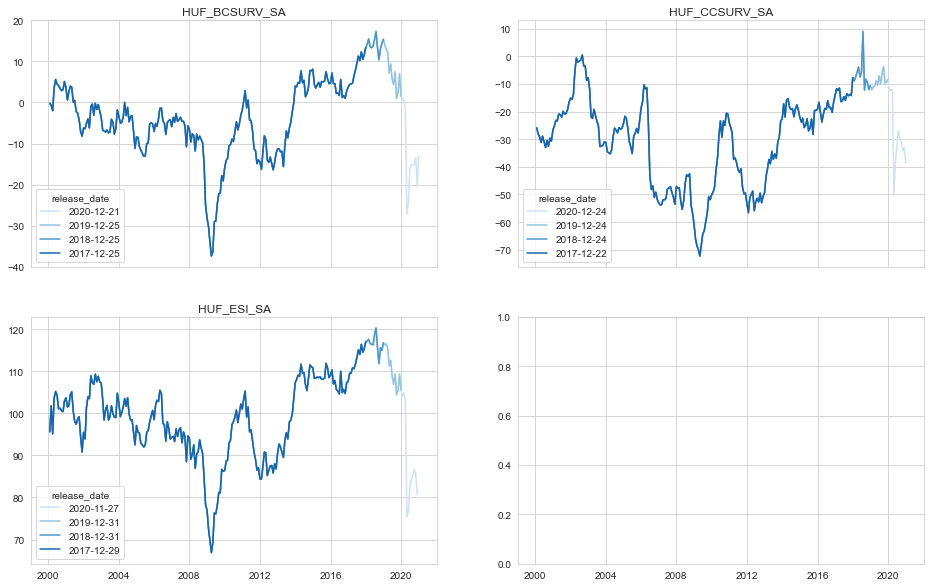

In [34]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_huf['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_huf['ticker'].isin(['HUF_BCSURV_SA', 'HUF_CCSURV_SA', 'HUF_ESI_SA'])
dfm_x = dfm_huf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10))

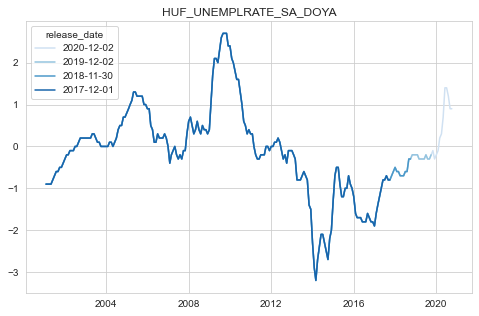

In [35]:
filt2 = dfm_huf['ticker'].isin(['HUF_UNEMPLRATE_SA'])
dfm_x = dfm_huf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

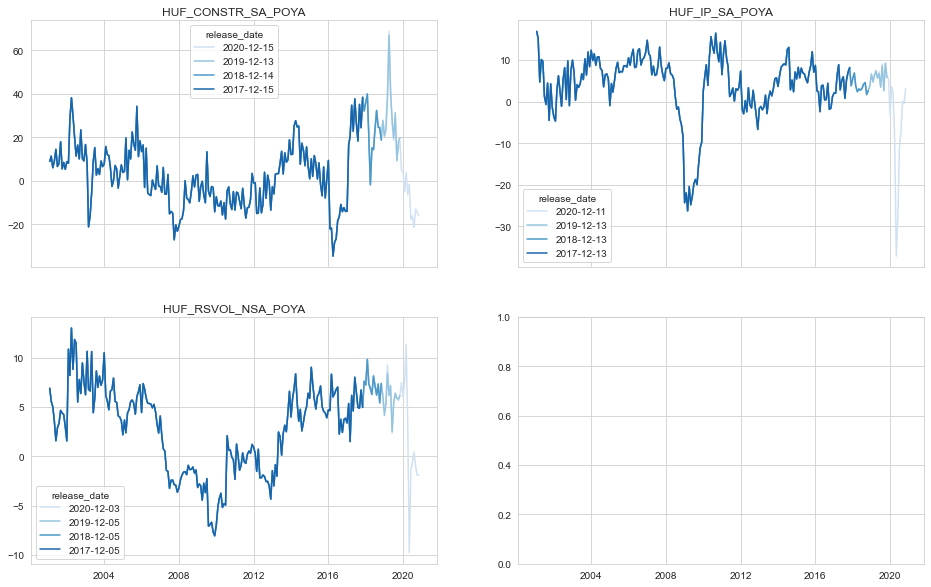

In [36]:
filt2 = dfm_huf['ticker'].isin(['HUF_CONSTR_SA', 'HUF_IP_SA', 'HUF_RSVOL_NSA'])
dfm_x = dfm_huf[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod='POYA')

## IDR

In [37]:
dfm_idr = dfm[dfm['cross_section'] == 'IDR']
np.sort(dfm_idr['ticker'].unique())

array(['IDR_CARSALES_NSA', 'IDR_IPMANU_NSA', 'IDR_RSVOL_NSA'],
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

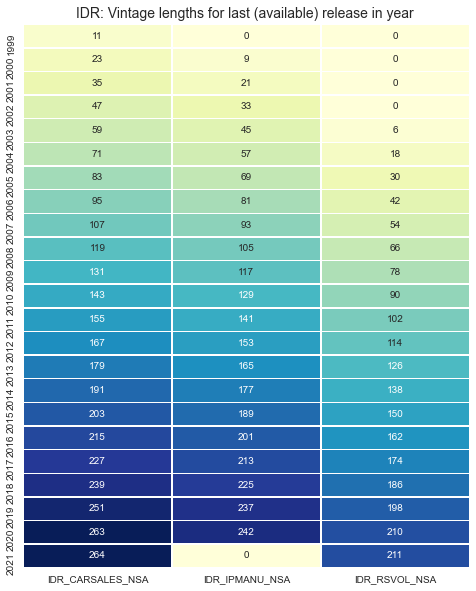

In [38]:
countmap(dfm_idr, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

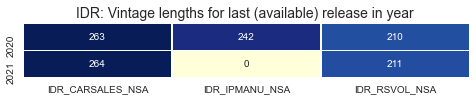

In [39]:
countmap(dfm_idr, 2000, (8, 1), trueVin = True)
plt.show

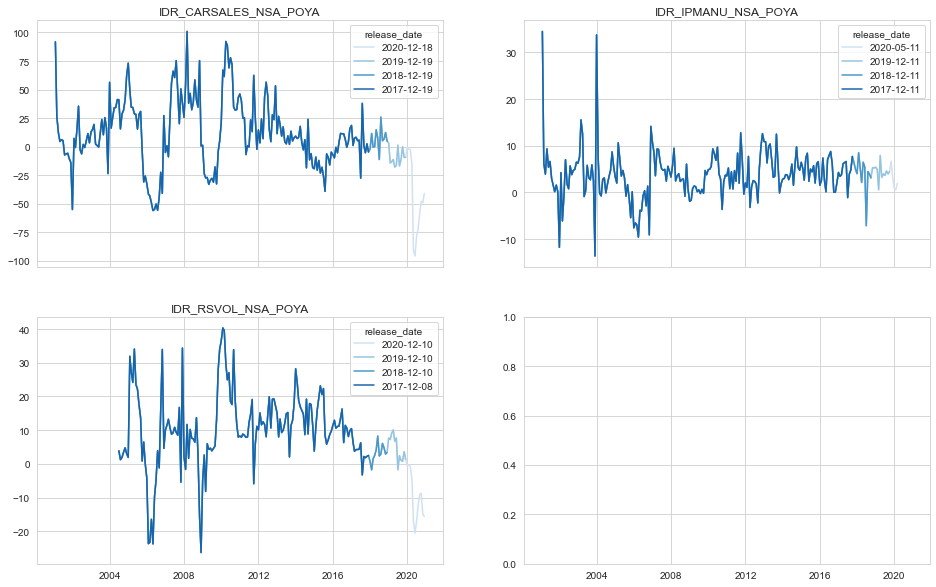

In [40]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_idr['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_idr['ticker'].isin(['IDR_CARSALES_NSA', 'IDR_IPMANU_NSA', 'IDR_RSVOL_NSA'])
dfm_x = dfm_idr[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod = 'POYA')

## INR

In [15]:
dfm_inr = dfm[dfm['cross_section'] == 'INR']
np.sort(dfm_inr['ticker'].unique())

array(['INR_IP_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

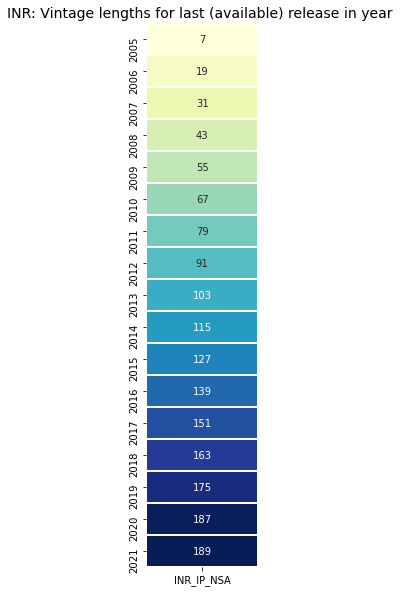

In [16]:
countmap(dfm_inr, 1990, (2, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

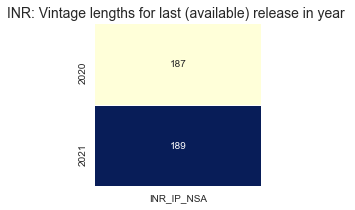

In [43]:
countmap(dfm_inr, 2000, (3, 3), trueVin = True)
plt.show

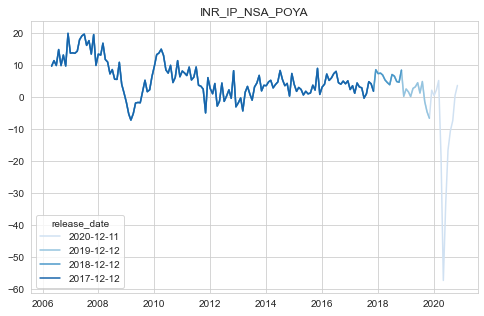

In [44]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_inr['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_inr['ticker'].isin(['INR_IP_NSA'])
dfm_x = dfm_inr[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'POYA')

## KRW

In [45]:
dfm_krw = dfm[dfm['cross_section'] == 'KRW']
np.sort(dfm_krw['ticker'].unique())

array(['KRW_ACTIND_NSA', 'KRW_BCSURV_NSA', 'KRW_ESI_NSA', 'KRW_IP_SA',
       'KRW_RSVOL_NSA', 'KRW_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

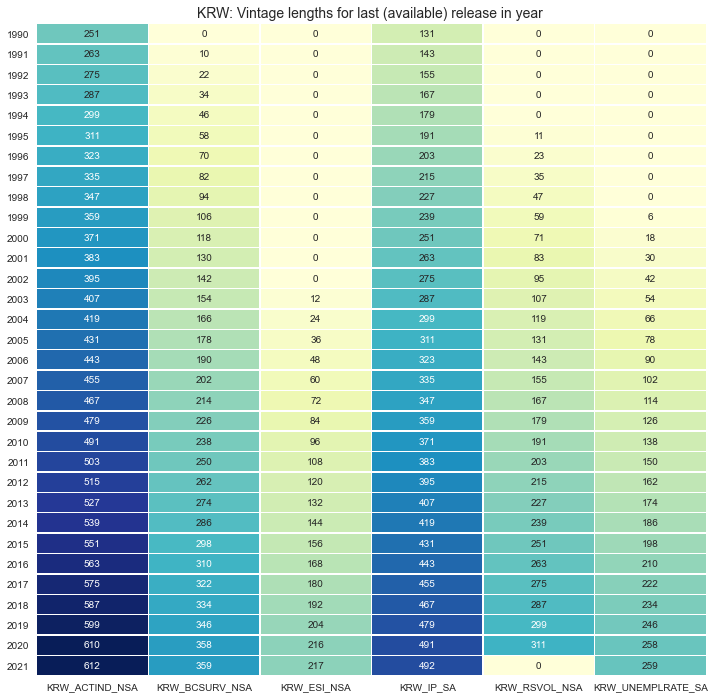

In [46]:
countmap(dfm_krw, 1990, (12, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

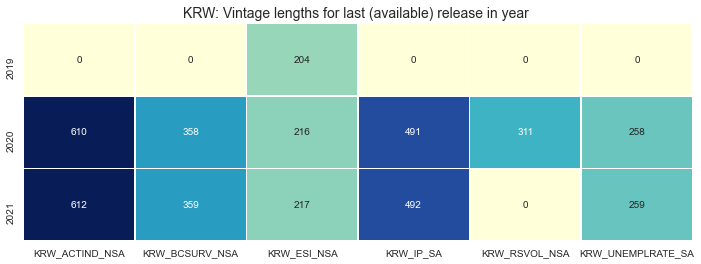

In [47]:
countmap(dfm_krw, 2000, (12, 4), trueVin = True)
plt.show

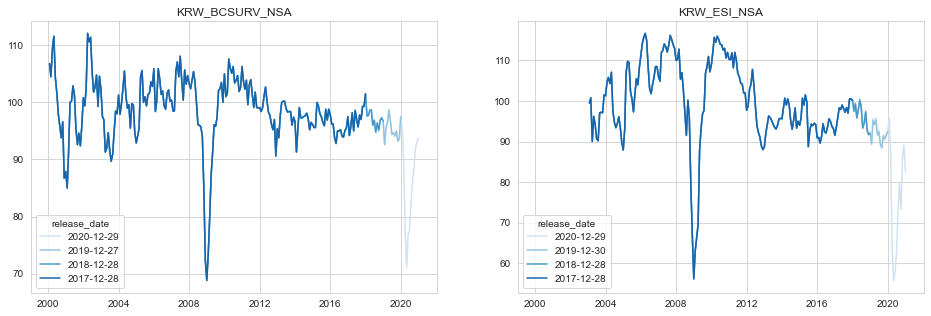

In [48]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_krw['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_krw['ticker'].isin(['KRW_BCSURV_NSA', 'KRW_ESI_NSA'])
dfm_x = dfm_krw[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

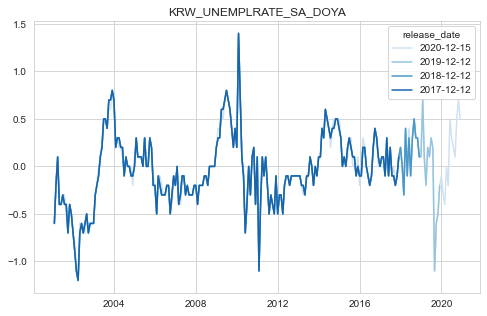

In [49]:
filt2 = dfm_krw['ticker'].isin(['KRW_UNEMPLRATE_SA'])
dfm_x = dfm_krw[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'DOYA')

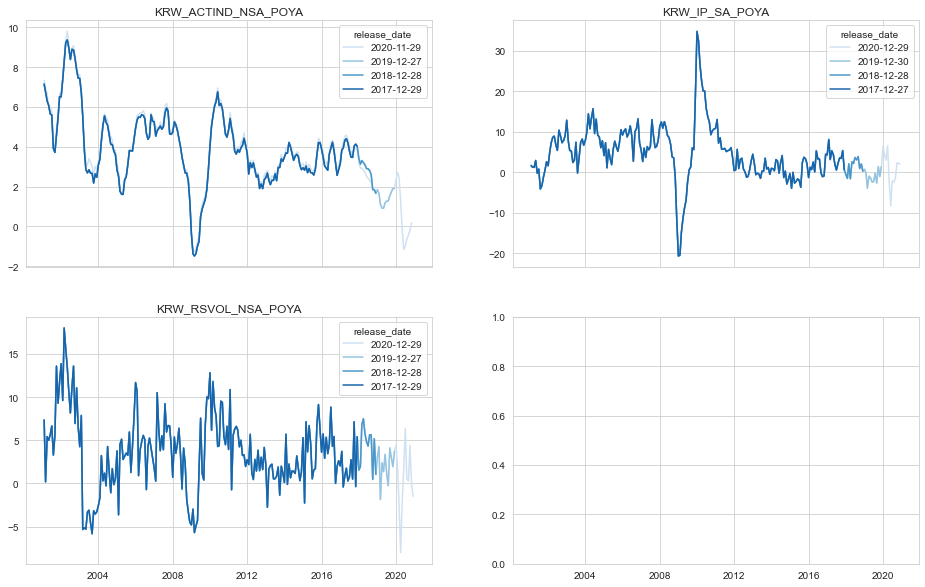

In [50]:
filt2 = dfm_krw['ticker'].isin(['KRW_ACTIND_NSA','KRW_IP_SA', 'KRW_RSVOL_NSA'])
dfm_x = dfm_krw[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod = 'POYA')

## MYR

In [12]:
dfm_myr = dfm[dfm['cross_section'] == 'MYR']
np.sort(dfm_myr['ticker'].unique())

array(['MYR_EMPL_NSA', 'MYR_IP_NSA', 'MYR_PMIMANU_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

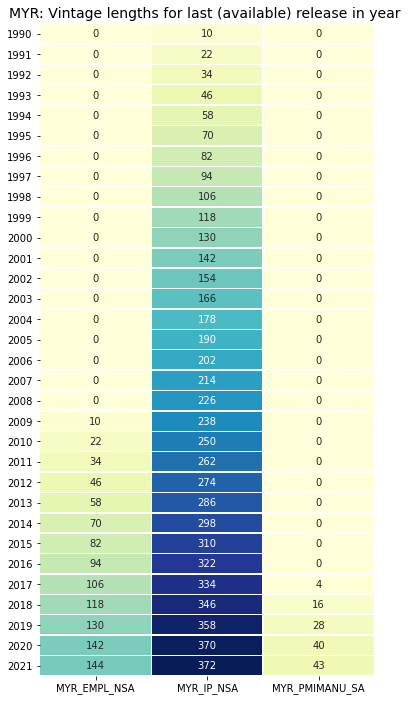

In [13]:
countmap(dfm_myr, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

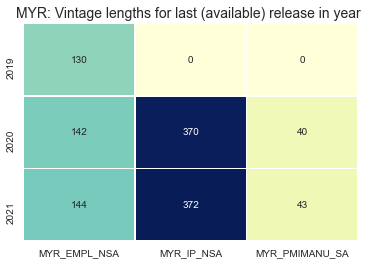

In [53]:
countmap(dfm_myr, 2000, (6, 4), trueVin = True)
plt.show

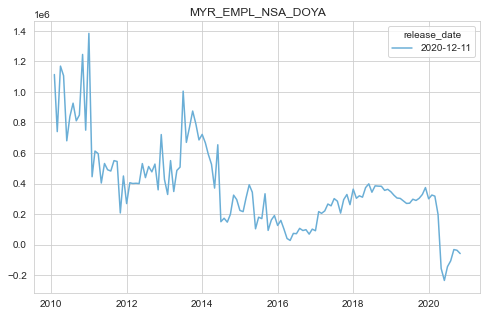

In [54]:
pots = ['2020-12-31'] # , '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_myr['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_myr['ticker'].isin(['MYR_EMPL_NSA'])
dfm_x = dfm_myr[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'DOYA')

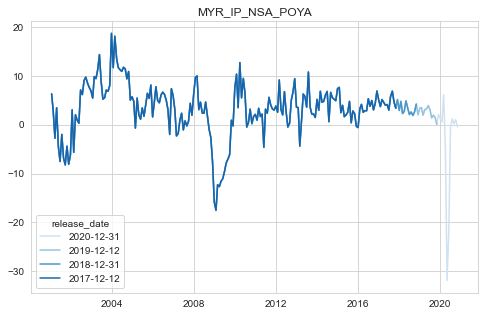

In [55]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt2 = dfm_myr['ticker'].isin(['MYR_IP_NSA'])
dfm_x = dfm_myr[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'POYA')

## MXN

In [56]:
dfm_mxn = dfm[dfm['cross_section'] == 'MXN']
np.sort(dfm_mxn['ticker'].unique())

array(['MXN_ACTIND_SA', 'MXN_IP_NSA', 'MXN_SURVMANU_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

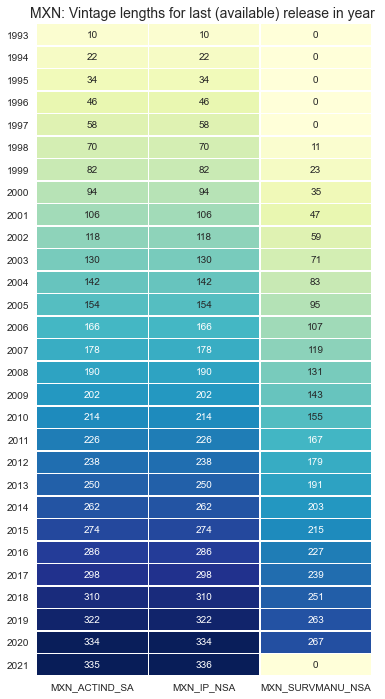

In [57]:
countmap(dfm_mxn, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

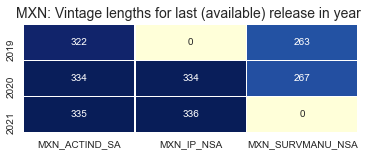

In [58]:
countmap(dfm_mxn, 2000, (6, 2), trueVin = True)
plt.show

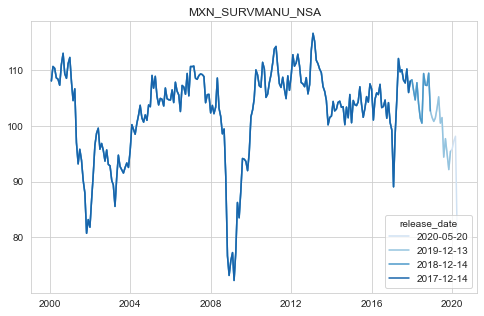

In [59]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_mxn['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_mxn['ticker'].isin(['MXN_SURVMANU_NSA'])
dfm_x = dfm_mxn[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

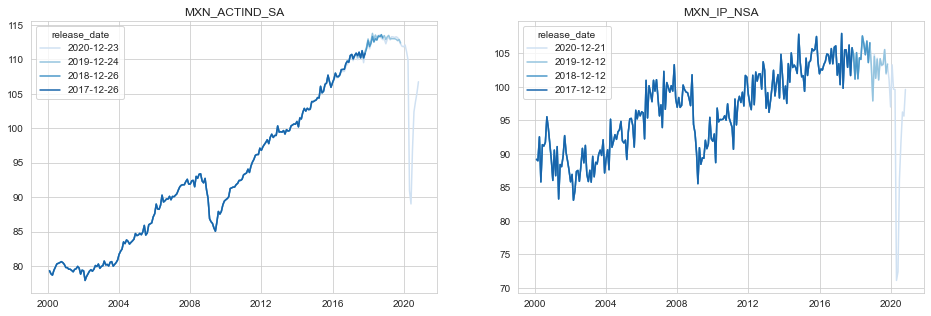

In [60]:
filt2 = dfm_mxn['ticker'].isin(['MXN_ACTIND_SA', 'MXN_IP_NSA'])
dfm_x = dfm_mxn[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

## PEN

In [61]:
dfm_pen = dfm[dfm['cross_section'] == 'PEN']
np.sort(dfm_pen['ticker'].unique())

array(['PEN_BCSURV_NSA', 'PEN_IP_NSA', 'PEN_MGDP_SA',
       'PEN_UNEMPLRATE_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

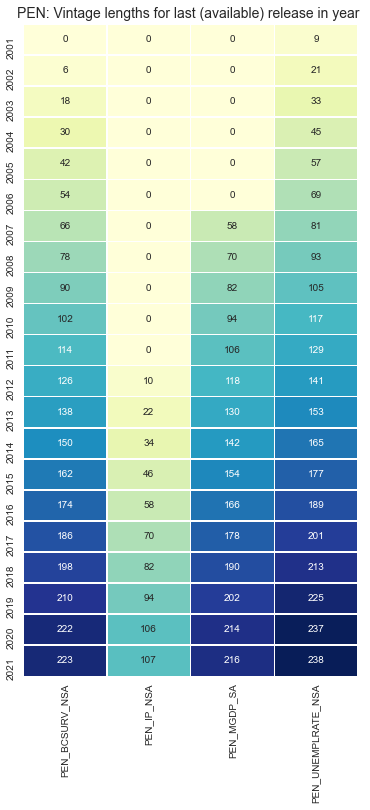

In [62]:
countmap(dfm_pen, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

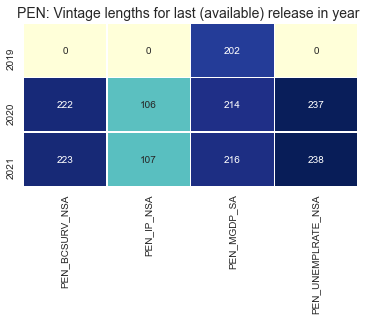

In [63]:
countmap(dfm_pen, 2000, (6, 3), trueVin = True)
plt.show

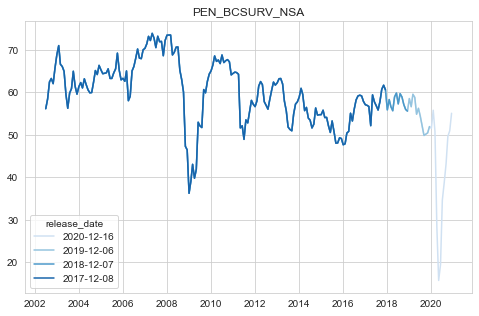

In [64]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_pen['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_pen['ticker'].isin(['PEN_BCSURV_NSA'])
dfm_x = dfm_pen[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

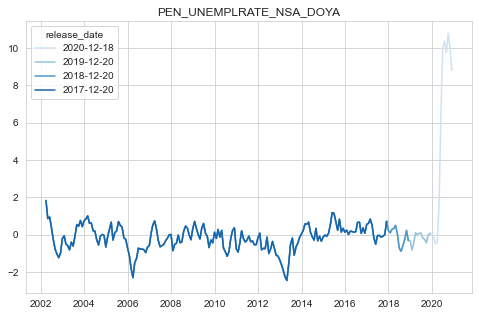

In [65]:
filt2 = dfm_pen['ticker'].isin(['PEN_UNEMPLRATE_NSA'])
dfm_x = dfm_pen[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'DOYA')

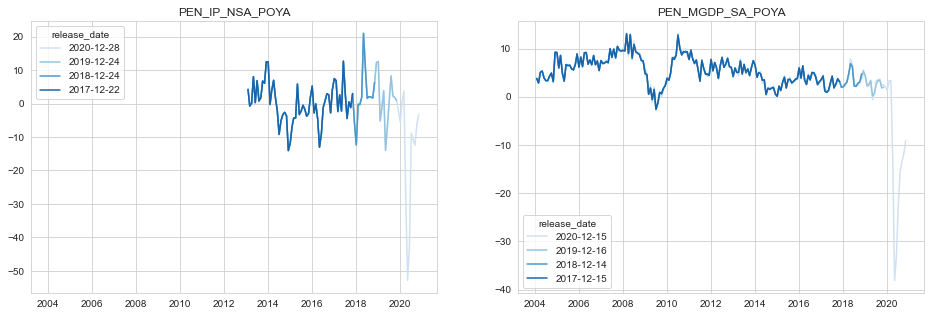

In [66]:
filt2 = dfm_pen['ticker'].isin(['PEN_IP_NSA', 'PEN_MGDP_SA'])
dfm_x = dfm_pen[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod = 'POYA')

## PHP

In [67]:
dfm_php = dfm[dfm['cross_section'] == 'PHP']
np.sort(dfm_php['ticker'].unique())

array(['PHP_CAPUTIL_NSA', 'PHP_CARSALES_NSA', 'PHP_IPMANU_NSA'],
      dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

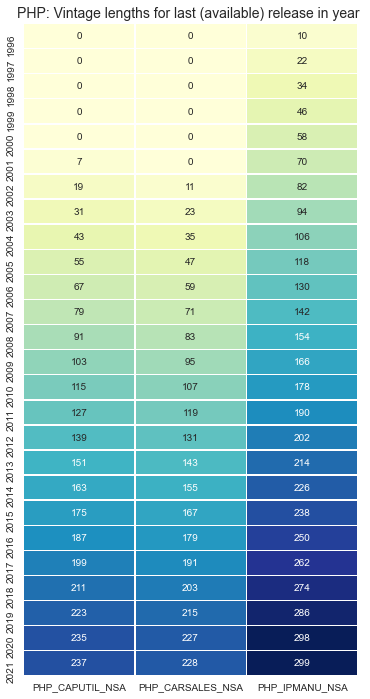

In [68]:
countmap(dfm_php, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

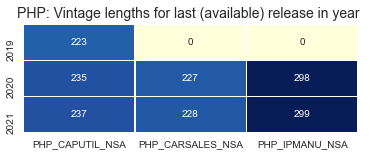

In [69]:
countmap(dfm_php, 2000, (6, 2), trueVin = True)
plt.show

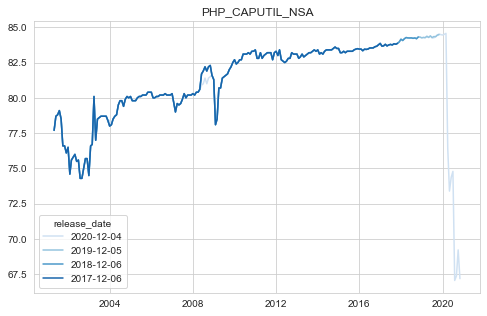

In [70]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_php['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_php['ticker'].isin(['PHP_CAPUTIL_NSA'])
dfm_x = dfm_php[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

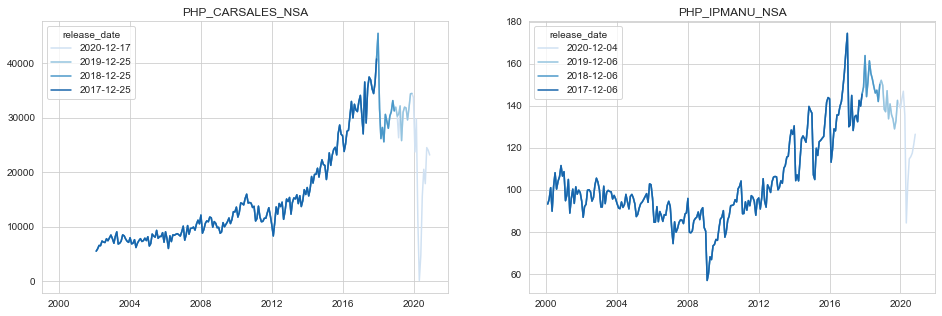

In [71]:
filt2 = dfm_php['ticker'].isin(['PHP_CARSALES_NSA', 'PHP_IPMANU_NSA'])
dfm_x = dfm_php[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

## PLN

In [72]:
dfm_pln = dfm[dfm['cross_section'] == 'PLN']
np.sort(dfm_pln['ticker'].unique())

array(['PLN_CCSURV_SA', 'PLN_ESI_SA', 'PLN_IP_SA', 'PLN_RSVAL_NSA',
       'PLN_SURVMANU_NSA', 'PLN_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

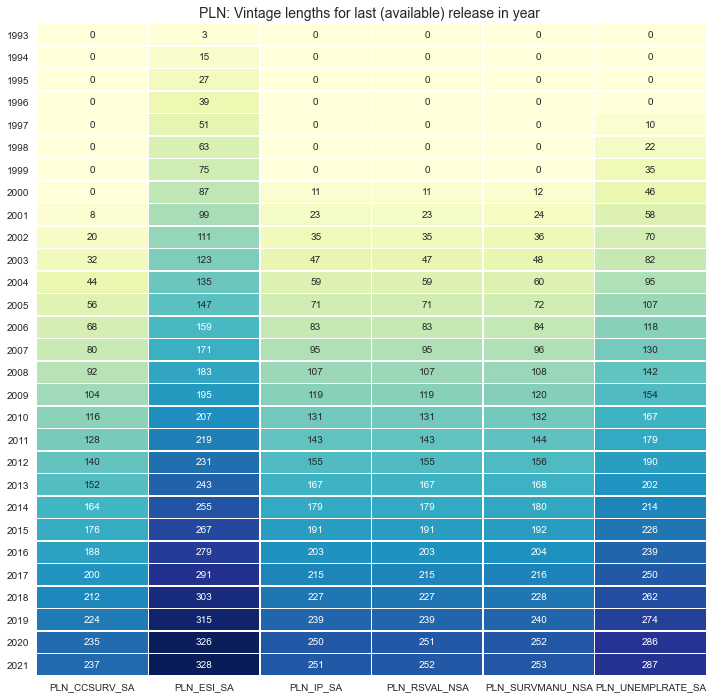

In [73]:
countmap(dfm_pln, 1990, (12, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

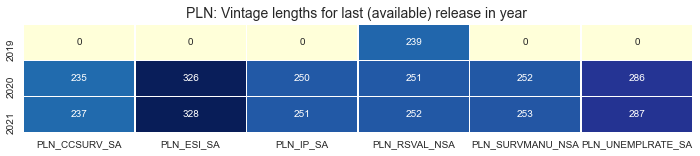

In [74]:
countmap(dfm_pln, 2000, (12, 2), trueVin = True)
plt.show

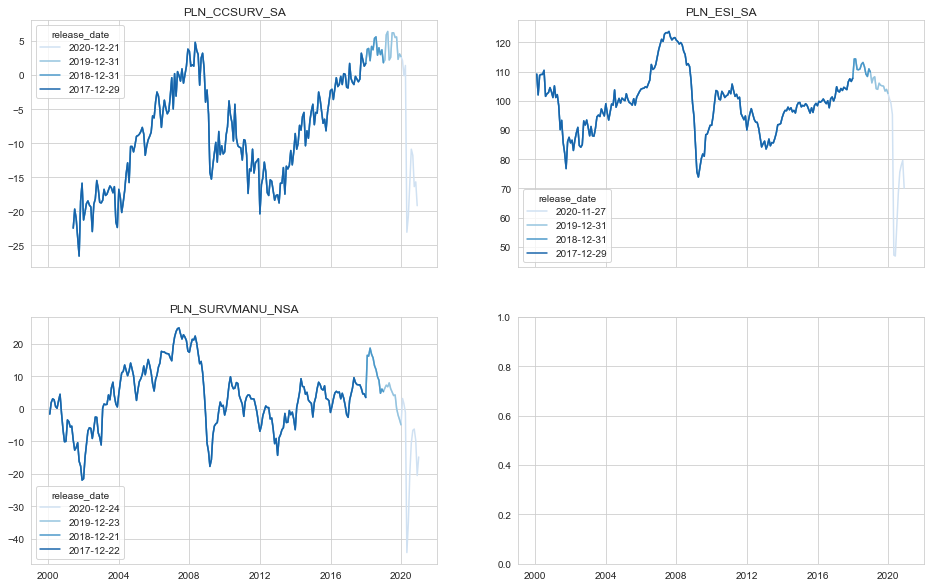

In [75]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_pln['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_pln['ticker'].isin(['PLN_CCSURV_SA', 'PLN_ESI_SA', 'PLN_SURVMANU_NSA'])
dfm_x = dfm_pln[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10))

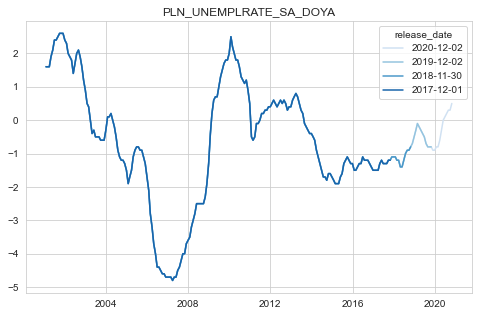

In [76]:
filt2 = dfm_pln['ticker'].isin(['PLN_UNEMPLRATE_SA'])
dfm_x = dfm_pln[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod='DOYA')

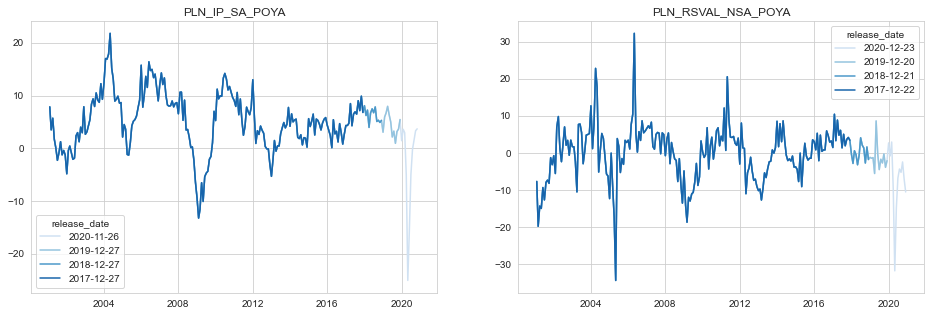

In [77]:
filt2 = dfm_pln['ticker'].isin(['PLN_IP_SA', 'PLN_RSVAL_NSA'])
dfm_x = dfm_pln[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod='POYA')

## RON

In [78]:
dfm_ron = dfm[dfm['cross_section'] == 'RON']
np.sort(dfm_ron['ticker'].unique())

array(['RON_EMPL_NSA', 'RON_ESI_SA', 'RON_IP_SA', 'RON_RSVOL_SA',
       'RON_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

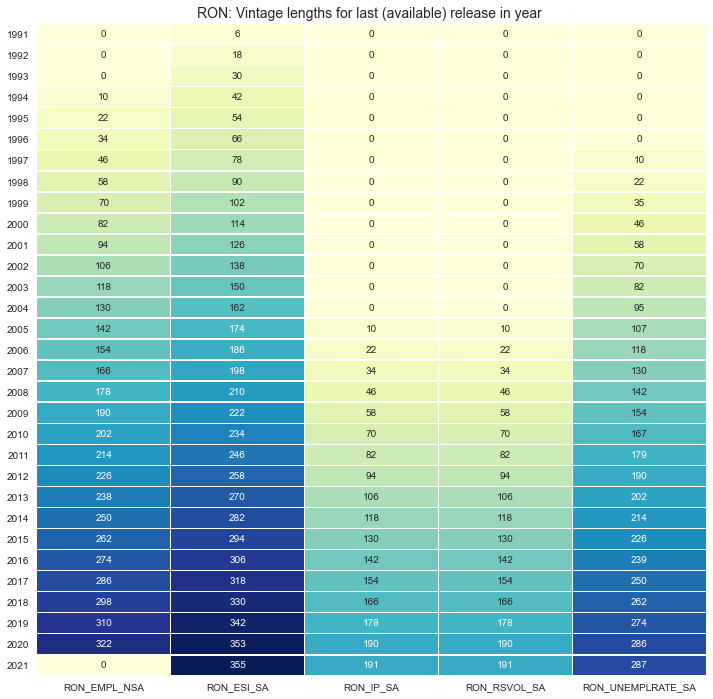

In [79]:
countmap(dfm_ron, 1990, (12, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

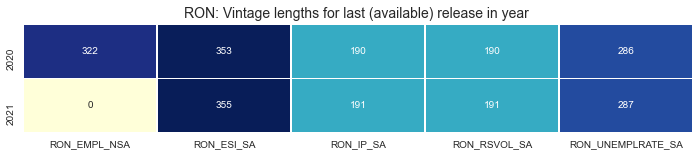

In [80]:
countmap(dfm_ron, 2000, (12, 2), trueVin = True)
plt.show

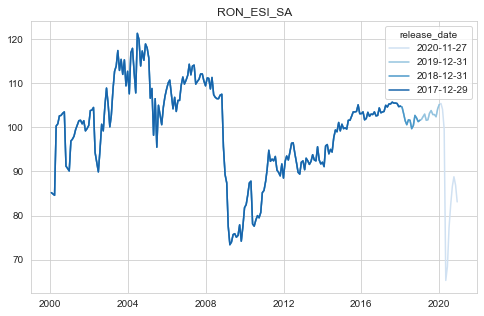

In [81]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_ron['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_ron['ticker'].isin(['RON_ESI_SA'])
dfm_x = dfm_ron[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

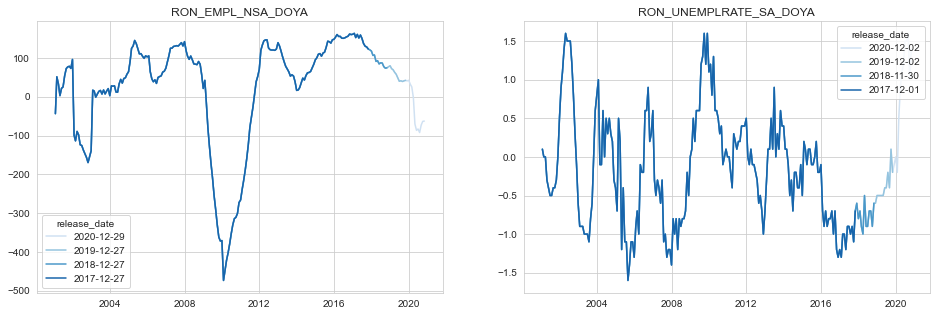

In [82]:
filt2 = dfm_ron['ticker'].isin(['RON_EMPL_NSA', 'RON_UNEMPLRATE_SA'])
dfm_x = dfm_ron[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod = 'DOYA')

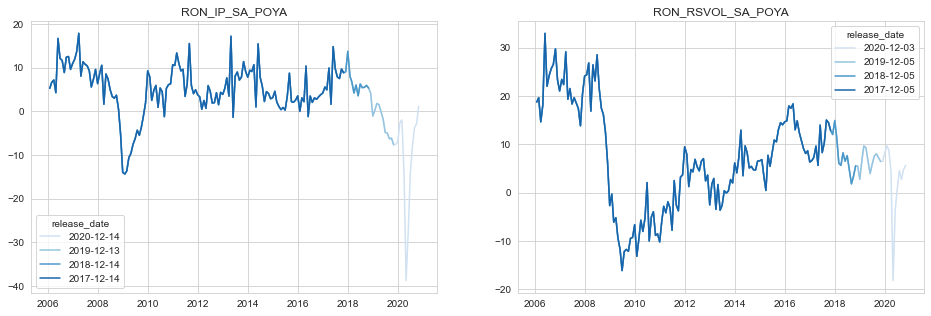

In [83]:
filt2 = dfm_ron['ticker'].isin(['RON_IP_SA', 'RON_RSVOL_SA'])
dfm_x = dfm_ron[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5), mod = 'POYA')

## RUB

In [12]:
dfm_rub = dfm[dfm['cross_section'] == 'RUB']
np.sort(dfm_rub['ticker'].unique())

array(['RUB_IP_NSA_P1M1ML12', 'RUB_MGDP_NSA_P1M1ML12',
       'RUB_UNEMPLRATE_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

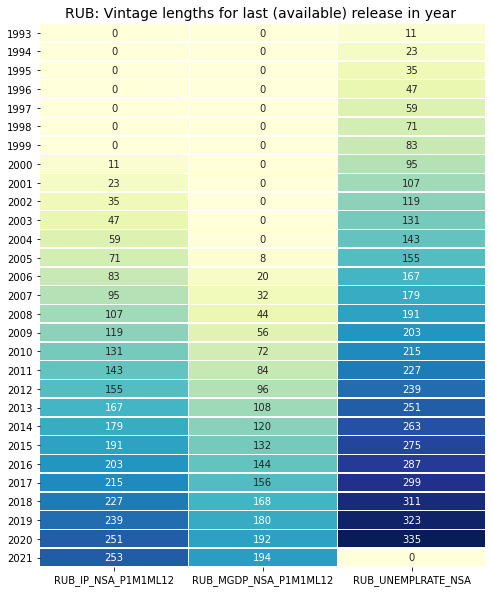

In [14]:
countmap(dfm_rub, 1990, (8, 10))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

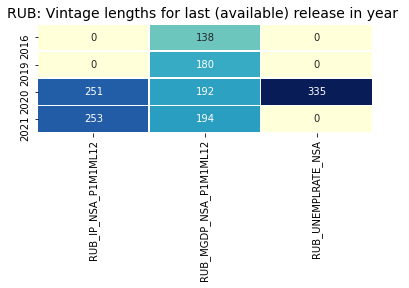

In [15]:
countmap(dfm_rub, 2000, (6, 2), trueVin = True)
plt.show

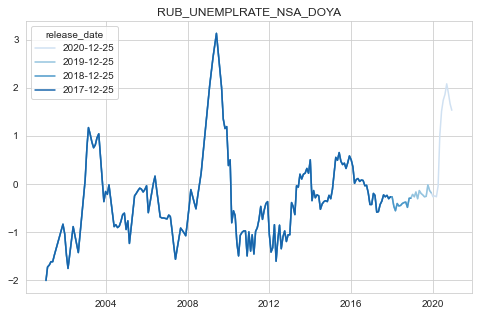

In [16]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_rub['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_rub['ticker'].isin(['RUB_UNEMPLRATE_NSA'])
dfm_x = dfm_rub[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'DOYA')

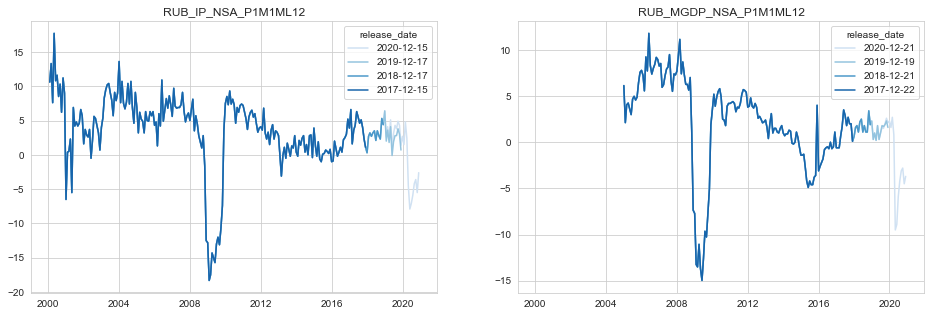

In [18]:
filt2 = dfm_rub['ticker'].isin(['RUB_IP_NSA_P1M1ML12', 'RUB_MGDP_NSA_P1M1ML12'])
dfm_x = dfm_rub[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

## SGD

In [89]:
dfm_sgd = dfm[dfm['cross_section'] == 'SGD']
np.sort(dfm_sgd['ticker'].unique())

array(['SGD_IPMANU_SA', 'SGD_PMICOMP_NSA', 'SGD_REXPORTS_SA',
       'SGD_RSVOL_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

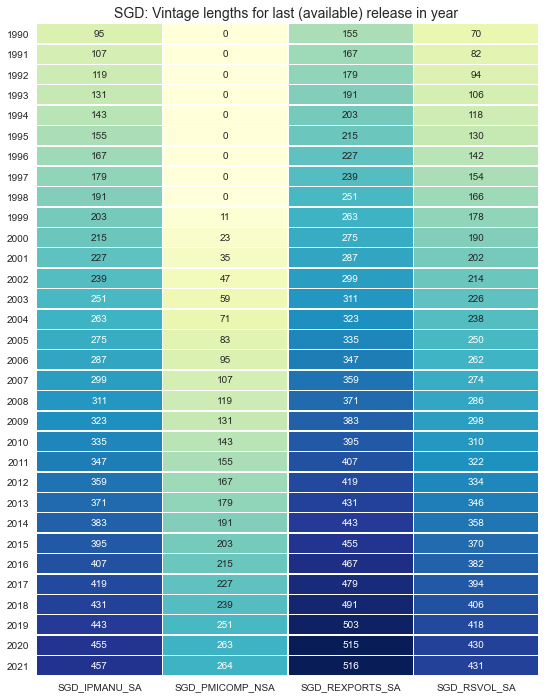

In [90]:
countmap(dfm_sgd, 1990, (9, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

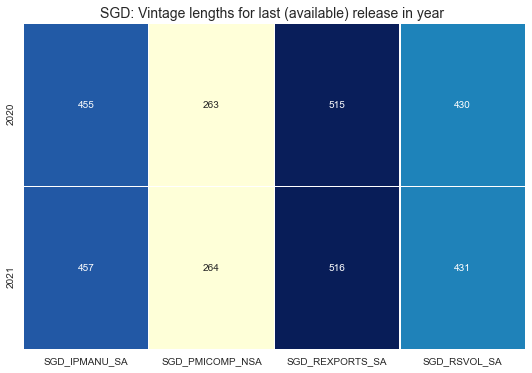

In [91]:
countmap(dfm_sgd, 2000, (9, 6), trueVin = True)
plt.show

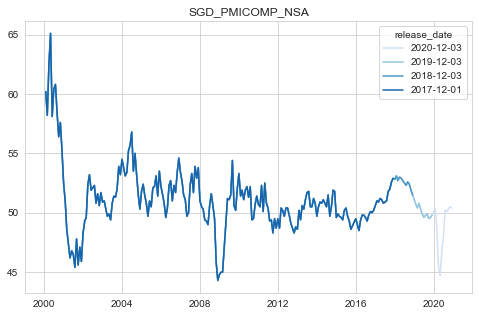

In [92]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_sgd['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_sgd['ticker'].isin(['SGD_PMICOMP_NSA'])
dfm_x = dfm_sgd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

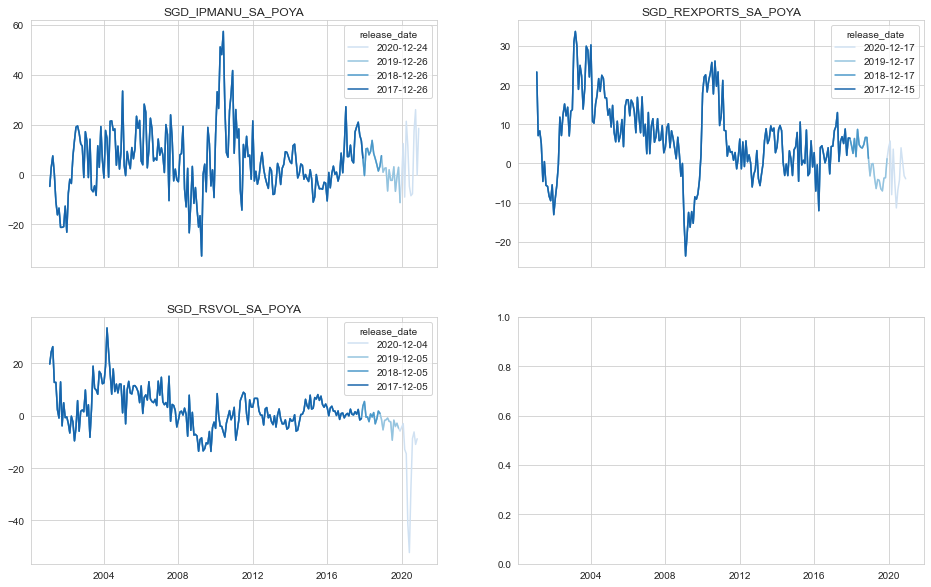

In [93]:
filt2 = dfm_sgd['ticker'].isin(['SGD_IPMANU_SA', 'SGD_REXPORTS_SA', 'SGD_RSVOL_SA'])
dfm_x = dfm_sgd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10), mod = "POYA")

## TRY

In [94]:
dfm_try = dfm[dfm['cross_section'] == 'TRY']
np.sort(dfm_try['ticker'].unique())

array(['TRY_BCSURV_NSA', 'TRY_CCSURV_NSA', 'TRY_IP_NSA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

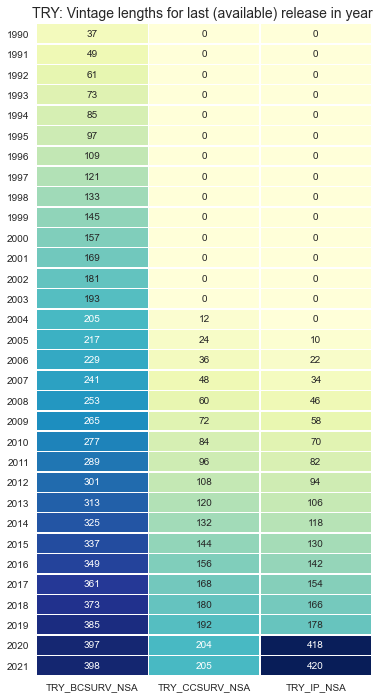

In [95]:
countmap(dfm_try, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

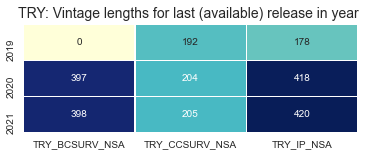

In [96]:
countmap(dfm_try, 2000, (6, 2), trueVin = True)
plt.show

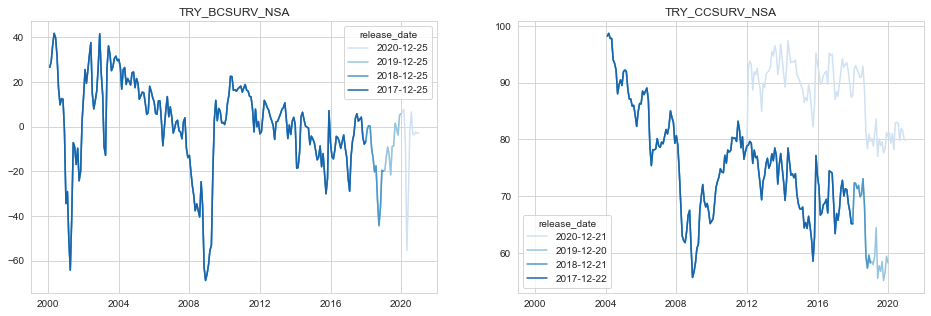

In [97]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_try['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_try['ticker'].isin(['TRY_BCSURV_NSA', 'TRY_CCSURV_NSA'])
dfm_x = dfm_try[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 5))

In [98]:
filt2 = dfm_try['ticker'].isin(['TRY_IP_SA'])
dfm_x = dfm_try[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'POYA')

<Figure size 576x360 with 0 Axes>

## TWD

In [99]:
dfm_twd = dfm[dfm['cross_section'] == 'TWD']
np.sort(dfm_twd['ticker'].unique())

array(['TWD_ACTIND_SA', 'TWD_IP_SA', 'TWD_SURVCOIN_SA',
       'TWD_UNEMPLRATE_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

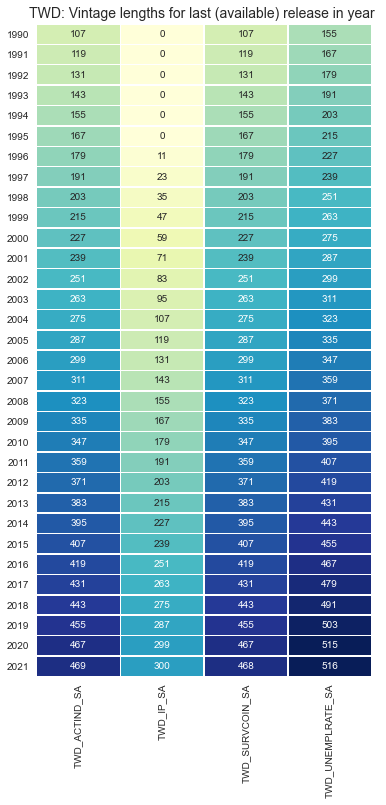

In [100]:
countmap(dfm_twd, 1990, (6, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

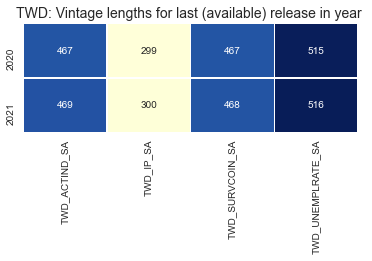

In [101]:
countmap(dfm_twd, 2000, (6, 2), trueVin = True)
plt.show

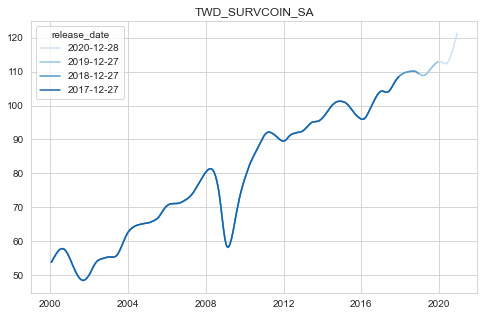

In [102]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_twd['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_twd['ticker'].isin(['TWD_SURVCOIN_SA'])
dfm_x = dfm_twd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

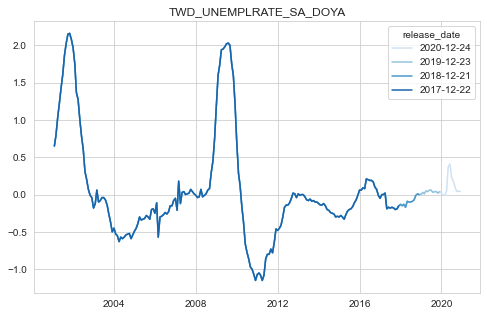

In [103]:
filt2 = dfm_twd['ticker'].isin(['TWD_UNEMPLRATE_SA'])
dfm_x = dfm_twd[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5), mod = 'DOYA')

## ZAR

In [104]:
dfm_zar = dfm[dfm['cross_section'] == 'ZAR']
np.sort(dfm_zar['ticker'].unique())

array(['ZAR_BCSURV_NSA', 'ZAR_IPMANU_SA', 'ZAR_IPMINING_SA',
       'ZAR_RSVOL_SA', 'ZAR_WSVOL_SA'], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

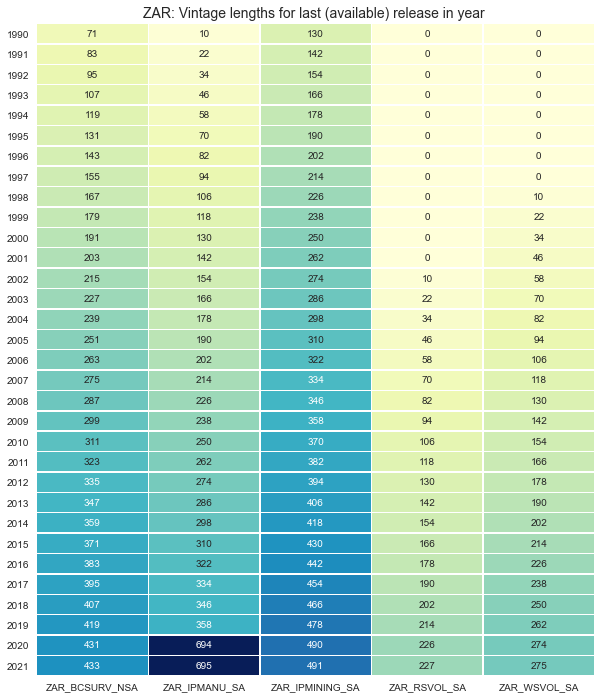

In [105]:
countmap(dfm_zar, 1990, (10, 12))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

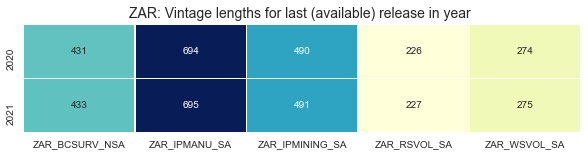

In [106]:
countmap(dfm_zar, 2000, (10, 2), trueVin = True)
plt.show

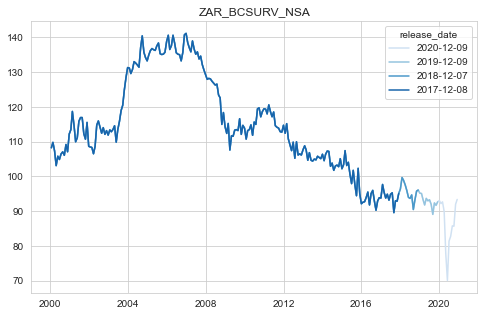

In [107]:
pots = ['2020-12-31', '2019-12-31', '2018-12-31', '2017-12-31']
filt1 = dfm_zar['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfm_zar['ticker'].isin(['ZAR_BCSURV_NSA'])
dfm_x = dfm_zar[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=1, size = (8, 5))

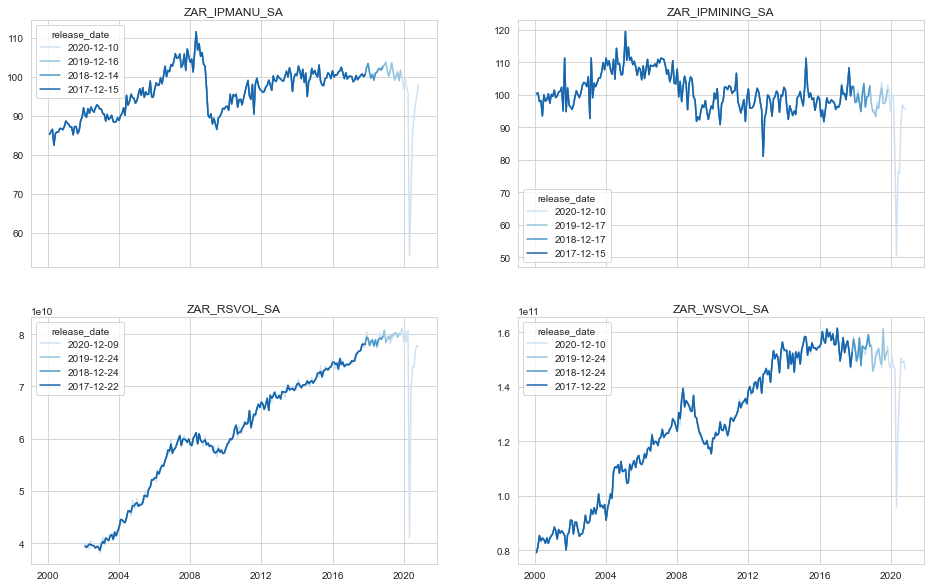

In [108]:
filt2 = dfm_zar['ticker'].isin(['ZAR_IPMANU_SA', 'ZAR_IPMINING_SA', 'ZAR_RSVOL_SA', 'ZAR_WSVOL_SA'])
dfm_x = dfm_zar[filt1 & filt2] 

revlines(dfm_x, pots=pots, ncols=2, size = (16, 10))